# Lab 5 (optional): Transfer Learning with PyTorch
**Remember to enable GPU ;-)**

This tutorial is inspired by a tutorial made by [Sasank Chilamkurthy](https://chsasank.github.io). You can find the original tutorial here:

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In this tutorial, you will learn how to train your network using
transfer learning. You can read more about the transfer learning at [cs231n
notes](http://cs231n.github.io/transfer-learning/).

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

Traditionally, people have distinguished between two types of transfer learning: finetuning and feature extraction. In **finetuning**, we start with a pretrained model and update all of the model’s parameters for our new task, in essence retraining the whole model. In **feature extraction**, we start with a pretrained model and only update the final layer weights from which we derive predictions. It is called feature extraction because we use the pretrained CNN as a fixed feature-extractor, and only change the output layer. For more technical information about transfer learning see here and here.

In practise, it is often best to combine the two approaches, simply because it makes training faster. There three basic steps:

1. **Initialize the model:** First download a pre-trained CNN. Use only the pre-trained convolutional base (encoder) and replace the final layers (decoder) with your own that you initialize with random weights.

2. **Feature extraction:** Freeze the weights of the convolutional base and train only the final layers. Train only for a few iterations. The purpose is simply to get a better starting point for finetuning.

3. **Finetuning:** Unfreeze the convolutional base and train the entire network.

However, before performing these steps, we need to load the data and set up dataloaders fro both training and validation.

## 1. Data loaders
First, include what's needed:

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

### 1.1 Download data
We will use [torchvision](https://pytorch.org/docs/stable/torchvision/index.html) and [torch.utils.data](https://pytorch.org/docs/stable/data.html) packages for loading the data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. This dataset is a very small subset of imagenet. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

First, let's download the data from [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip) and extract it to the current directory.

In [2]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "hymenoptera_data"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://download.pytorch.org/tutorial/"
FILENAME = "hymenoptera_data.zip"

if not (DATA_PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (DATA_PATH / FILENAME).open("wb").write(content)

In [3]:
import zipfile
with zipfile.ZipFile((DATA_PATH / FILENAME).as_posix(), "r") as f:
    f.extractall(DATA_PATH)

Check that the file has been downloaded and unzipped:

In [4]:
!ls data/hymenoptera_data

train  val


### 1.2 Simple data loader
Let's set up a simple [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) based on [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) and visualize some training examples.

- ImageFolder is a generic data set where the images are arranged in sub-folders corresponding to classes.
- DataLoader combines a dataset and a sampler, and provides an iterable over the given dataset.



In [6]:
# The transformer is used here to reshape images to 224x224 and convert to tensor
simple_transformer = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor()])

data_dir = os.path.join(str(PATH), 'train') # 'data/hymenoptera_data/train'

# ImageFolder is a generic data set where the images are arranged in sub-folders corresponding to classes
train_set = datasets.ImageFolder(data_dir,simple_transformer)

# Combines a dataset and a sampler, and provides an iterable over the given dataset.
dataloader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=4)

class_names = train_set.classes

Shuffling the order in which the training samples are loaded is important ([Read why here](https://www.quora.com/Does-the-order-of-training-data-matter-when-training-neural-networks)). PyTorch's DataLaoder automatically shuffles the samples if you set `shuffle=True`.

Loading and preprocessing the training samples can sometimes slow down the training process. To address this, we can tell the DataLoader to run multiple sub-processes. This is what `num_workers=4` does.

Get a batch of training images and display it:

In [7]:
%matplotlib inline

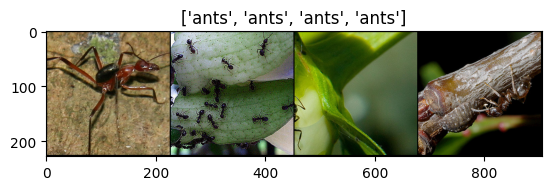

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# Get a random batch of training data
inputs, classes = next(iter(dataloader))

# Make a grid of images
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### 1.3 Data augmentation
We can add more variation to the training data by using data augmentation. We can do this using PyTorch's [transformer](https://pytorch.org/vision/stable/transforms.html).


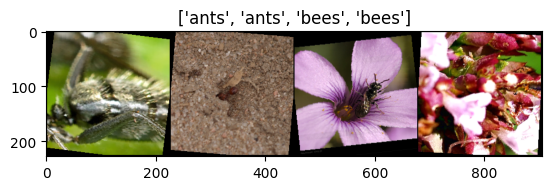

In [9]:
# Data augmentation transformer
augmentation_transformer = transforms.Compose([
        transforms.RandomResizedCrop(224), # Crop the given PIL Image to random size and aspect ratio
        transforms.RandomHorizontalFlip(0.5), # Horizontally flip the given PIL Image randomly with a given probability.
        transforms.ColorJitter(brightness=0.1), # Randomly change the brightness, contrast and saturation of an image
        transforms.RandomRotation(degrees=10), # Rotate the image by angle.
        transforms.ToTensor()])

# Same as above, expect that we are using augmentation_transformer instead of simple_transformer
train_set = datasets.ImageFolder(data_dir, augmentation_transformer)
dataloader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=4)
inputs, classes = next(iter(dataloader))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

You might wonder, what's the motivation for using data augmentation? The best form of regularization (i.e., avoiding overfitting) is adding more data. Data augmentation adds more data synthetically. Another way to think about data augmentation is that random transformations of the training images makes it harder for the model to memorize the training data.

But be careful which transformations you choose. For instance, `transforms.RandomHorizontalFlip` would not be applicable on the MNIST dataset (Handwritten digits). Why? Because, when performing data augmentation the semantics (i.e., the class label) should be preserved. If you flip, say, a 2 horizontally it is no longer a valid 2.

### 1.4 Set up data loaders for both training and validation
Finally, we are ready to create data loaders for both training and validation.

Notice that we use dictionaries (curly brackets) here to store both train and val in the same variable.

In [10]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ColorJitter(brightness=0.1),
        transforms.RandomRotation(degrees=10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = str(PATH) # 'data/hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Recall makes optimization easier if the inputs are centered around zero (see lecture 5). In the code above, the input data is normalized by this transformation:
```
transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
```
This normalizes the input intensities so that they are centered around zero. The formula is
```
output[channel] = (input[channel] - mean[channel]) / std[channel]
```
where in our case mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].

Note that this normalization assumes that the input pixel values are floats in the range 0 to 1.

Visualize a few images.

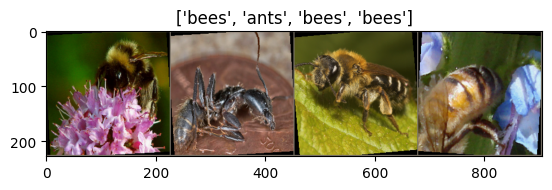

In [11]:
# Redefine imshow to handle normalization
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))

    #undo normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## 2. Initialize the model
PyTorch has a number of pretrained models that you can choose from. See complete list [here](https://pytorch.org/vision/stable/models.html).

We will be using resnet18 here. Let's download the weights:

In [12]:
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 61.0MB/s]


### 2.1 Displaying the network architecture
You can print the model and its layers.

In [13]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

To see individual layers, simply dot your way into the model using the names in the list above.

In [14]:
print(model.layer1) # First convolutional block
print(model.fc) # Final fully connected layer

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
Linear(in_features=512, out_features=1000, bias=True)


Looking at the final `Linear` layer, the property `out_features=1000` tells us that the network outputs a 1000-dimensional vector. This is because it was trained on ImageNet dataset, which has 1000 classes.

Similarly, `in_features=512` tells is that the input vector to the final layer must be a 512-dimensional vector.


### 2.2 Reshape final layer
Let's change the number of ouputs to 2 instead (for bees and ants).

In [15]:
# Size of input vector to fully connected layer
num_ftrs = model.fc.in_features # 512

# Replace fully connected layer
model.fc = nn.Linear(num_ftrs, 2)

print(model.fc)

Linear(in_features=512, out_features=2, bias=True)


## 3. Set up general training function
Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model (read more [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html))

In the following, parameter ``scheduler`` is a learning rate scheduler object from [``torch.optim.lr_scheduler``](https://pytorch.org/docs/stable/optim.html).



In [16]:
# Generic function to train a model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Copy weights
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history only if in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [17]:
# Generic function to display predictions for a few images
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(2, num_images//2, images_so_far)
                ax.axis('off')
                ax.set_title('pred/true: {}/{}'.format(class_names[preds[j]],
                                                       class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## 4. Feature extraction
Freeze the weights of the convolutional base and train only the final fully connected layer. Train only for a few iterations. The purpose is simply to get a better starting point for finetuning.

We want to set set the ``.requires_grad attribute`` of the parameters in the conovolutional base to ``False``. By default, when we load a pretrained model all of the parameters have ``.requires_grad=True``, which is fine if we are training from scratch or finetuning. However, if we are feature extracting and only want to compute gradients for the newly initialized layer(s) then we want all of the other parameters to not require gradients.

You can read more about this in the documentation [here](http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward).


In [18]:
# Freeze all layers (i.e., disable training)
for param in model.parameters():
    param.requires_grad = False

# Unfreeze final layer (named fc)
for param in model.fc.parameters():
    param.requires_grad = True

# Put the model on the GPU
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

### 4.1 Train and evaluate
It should take around 5-10 min on CPU. On GPU though, it takes less than half a
minute.

In [19]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


train Loss: 0.6391 Acc: 0.6107
val Loss: 0.3872 Acc: 0.7974

Epoch 1/4
----------
train Loss: 0.4601 Acc: 0.8074
val Loss: 0.2665 Acc: 0.9020

Epoch 2/4
----------
train Loss: 0.4657 Acc: 0.7787
val Loss: 0.2059 Acc: 0.9412

Epoch 3/4
----------
train Loss: 0.6116 Acc: 0.7500
val Loss: 0.2098 Acc: 0.9412

Epoch 4/4
----------
train Loss: 0.7552 Acc: 0.7213
val Loss: 0.2877 Acc: 0.8889

Training complete in 0m 17s
Best val Acc: 0.941176


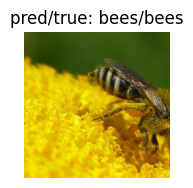

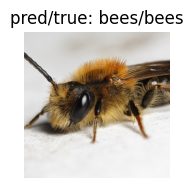

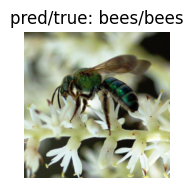

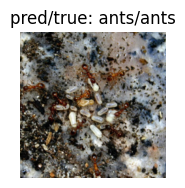

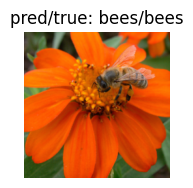

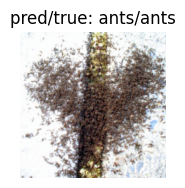

In [20]:
visualize_model(model)

## 5. Fine-tune model
Finally, let's unfreeze all layers to fine-tune the model.

In [21]:
# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

### 5.1 Train and evaluate
On CPU this will take more time compared to the previous scenario.
This is expected as gradients need to be computed for most of the
network.

In [22]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.5012 Acc: 0.7951
val Loss: 0.3415 Acc: 0.8758

Epoch 1/9
----------
train Loss: 0.4171 Acc: 0.8074
val Loss: 0.2503 Acc: 0.9085

Epoch 2/9
----------
train Loss: 0.3874 Acc: 0.8197
val Loss: 0.2312 Acc: 0.9150

Epoch 3/9
----------
train Loss: 0.3967 Acc: 0.8402
val Loss: 0.2343 Acc: 0.9412

Epoch 4/9
----------
train Loss: 0.2604 Acc: 0.8730
val Loss: 0.2506 Acc: 0.9085

Epoch 5/9
----------
train Loss: 0.2986 Acc: 0.8770
val Loss: 0.2314 Acc: 0.9216

Epoch 6/9
----------
train Loss: 0.3378 Acc: 0.8361
val Loss: 0.2305 Acc: 0.9216

Epoch 7/9
----------
train Loss: 0.3293 Acc: 0.8648
val Loss: 0.2231 Acc: 0.9346

Epoch 8/9
----------
train Loss: 0.3843 Acc: 0.8156
val Loss: 0.2380 Acc: 0.9216

Epoch 9/9
----------
train Loss: 0.3120 Acc: 0.8525
val Loss: 0.2174 Acc: 0.9346

Training complete in 0m 34s
Best val Acc: 0.941176


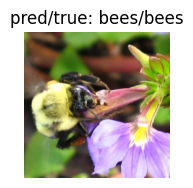

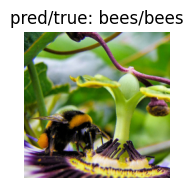

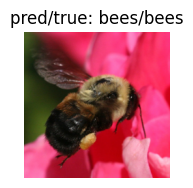

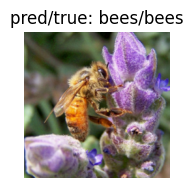

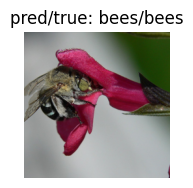

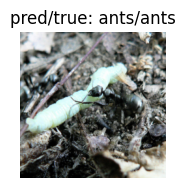

In [23]:
visualize_model(model)

plt.ioff()
plt.show()

## Suggestions for optional tasks
- Try re-running the above tutorial with another data set (see list [here](https://pytorch.org/vision/stable/datasets.html)) or a different CNN architecture (get inspiration [here](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)).

- [Object detection finetuning tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html) (use [this](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/torchvision_finetuning_instance_segmentation.ipynb) notebook if you are working in Google Colab).

![alt text](https://pytorch.org/tutorials/_static/img/tv_tutorial/tv_image01.png)

![alt text](https://pytorch.org/tutorials/_images/stn-arch.png)

- How does [Neural Style Transfer](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html) work?

![alt text](https://pytorch.org/tutorials/_images/neuralstyle.png)

- [Adversarial attacks](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html): You may be surprised to find that adding imperceptible perturbations to an image can cause drastically different model performance.

![](https://pytorch.org/tutorials/_images/fgsm_panda_image.png)

- [DCGAN tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html): Dream up fake celebrities.

![](https://pytorch.org/tutorials/_images/sphx_glr_dcgan_faces_tutorial_003.png)